In [47]:
from __future__ import division
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from glob import glob
import time
import os
import cv2

from ops import *
from utils import *

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = '../input/celeba-dataset/img_align_celeba/img_align_celeba' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=1024 # Length of first tensor in generator, as per architecture below

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [18]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [90]:
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    g_batch_norm_0 = batch_norm(name='g_batch_norm_0')
    h_0_bn = g_batch_norm_0(h_in, is_training)
    h_0_a = lrelu(h_0_bn, name='g_lr_0')
    
    h_1 = deconv2d(h_0_a, output_shape=[BATCH_SIZE, 8, 8, 512], name='g_deconv2d_1')
    g_batch_norm_1 = batch_norm(name='g_batch_norm_1')
    h_1_bn = g_batch_norm_1(h_1, is_training)
    h_1_a = lrelu(h_1_bn, name='g_lr_1')
    h_1_a_dr = tf.nn.dropout(h_1_a, 0.5, name='g_dr_1')
    
    h_2 = deconv2d(h_1_a_dr, output_shape=[BATCH_SIZE, 16, 16, 256], name='g_deconv2d_2')
    g_batch_norm_2 = batch_norm(name='g_batch_norm_2')
    h_2_bn = g_batch_norm_2(h_2, is_training)
    h_2_a = lrelu(h_2_bn, name='g_lr_2')
    h_2_a_dr = tf.nn.dropout(h_2_a, 0.5, name='g_dr_2')
    
    h_3 = deconv2d(h_2_a_dr, output_shape=[BATCH_SIZE, 32, 32, 128], name='g_deconv2d_3')
    g_batch_norm_3 = batch_norm(name='g_batch_norm_3')
    h_3_bn = g_batch_norm_3(h_3, is_training)
    h_3_a = lrelu(h_3_bn, name='g_lr_3')  
    
    h_out = deconv2d(h_3_a, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [91]:
def discriminator(image, is_training, batch_norms=None):
    
    d_0_conv2d = conv2d(image, output_dim=32, name='d_0_conv2d') #5x5 filters with stride of 2
    d_0_bnorm = batch_norm(name = 'd_0_norm')
    h_0_bnorm = d_0_bnorm(d_0_conv2d, is_training)
    h_0_activation = lrelu(h_0_bnorm, name = 'd_0_lrelu')
    d_0_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='d_0_pool')
    h_0_pool = d_0_pool(h_0_activation)
    
    d_1_conv2d = conv2d(h_0_pool, output_dim=64, name='d_1_conv2d')
    d_1_bnorm = batch_norm(name = 'd_1_norm')
    h_1_bnorm = d_1_bnorm(d_1_conv2d, is_training)
    h_1_activation = lrelu(h_1_bnorm, name = 'd_1_lrelu')
    d_1_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='d_1_pool')
    h_1_pool = d_1_pool(h_1_activation)
    
    d_2_conv2d = conv2d(h_1_pool, output_dim=128, name='d_2_conv2d') 
    d_2_bnorm = batch_norm(name = 'd_2_norm')
    h_2_bnorm = d_2_bnorm(d_2_conv2d, is_training)
    h_2_activation = lrelu(h_2_bnorm, name = 'd_2_lrelu')
    #d_2_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='d_0_pool')
    #h_2_pool = d_2_pool(h_2_activation)
    
    d_3_conv2d = conv2d(h_2_activation, output_dim=256, name='d_3_conv2d') 
    d_3_bnorm = batch_norm(name = 'd_3_norm')
    h_3_bnorm = d_3_bnorm(d_3_conv2d, is_training)
    h_3_activation = lrelu(h_3_bnorm, name = 'd_3_lrelu')
    
    d_flat = tf.keras.layers.Flatten()(h_3_activation)
    
    d_4_linear = linear(d_flat, 256, 'd_4_linear')
    d_4_bnorm = batch_norm(name='d_4_norm')
    h_4_bnorm = d_4_bnorm(d_4_linear, is_training)
    h_4_activation = lrelu(h_4_bnorm,name='d_4_lrelu')

    linear_out = linear(h_4_activation,1,'linear_out')
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [5]:
tf.compat.v1.disable_eager_execution()

In [92]:
#tf.reset_default_graph()
ops.reset_default_graph()
is_training = tf.compat.v1.placeholder(tf.bool, name='is_training')

with tf.compat.v1.variable_scope("G") as scope:
    z = tf.compat.v1.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.compat.v1.variable_scope('D') as scope:
    images = tf.compat.v1.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [93]:
"""
        You code goes here. Define discriminator and generator losses
"""
d_loss_real = -tf.reduce_mean(tf.math.log(D_real + 1e-30))

d_loss_fake = -tf.reduce_mean(tf.math.log(1 - D_fake + 1e-30))

d_loss = d_loss_real + d_loss_fake

g_loss = -tf.reduce_mean(tf.math.log(D_fake + 1e-30))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [94]:
tvars = tf.compat.v1.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.compat.v1.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.compat.v1.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data:

In [11]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

Functions for training and evaluations.

In [12]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.compat.v1.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

In [13]:
# %% [code]
# Original Version: Taehoon Kim (http://carpedm20.github.io)
#   + Source: https://github.com/carpedm20/DCGAN-tensorflow/blob/e30539fb5e20d5a0fed40935853da97e9e55eee8/utils.py
#   + License: MIT
from __future__ import division
import math
import random


def get_image(image_path, image_size, is_crop=True):
    return transform(imread(image_path), image_size, is_crop)

def save_images(images, size, image_path):
    imsave(inverse_transform(images), size, image_path)

def imread(path):
    return plt.imread(path).astype(np.float)

def merge_images(images, size):
    return inverse_transform(images)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((int(h * size[0]), int(w * size[1]), 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    img = merge(images, size)
    plt.imsave(path, (255*img).astype(np.uint8))
    #return scipy.misc.imsave(path, (255*img).astype(np.uint8))

def transform(image, npx=64, is_crop=True):
    return np.array(cv2.resize(image, (npx,npx)))/127.5 - 1.

def inverse_transform(images):
    return (images+1.)/2.

## Training GAN (1 point + 2 for good results)

In [95]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='../outputs/sample-face',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=15, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.compat.v1.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.compat.v1.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = 100#min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, MERGE_X],os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sampled")

In [62]:
#! mkdir '../output/sample-face'
os.mkdir('../outputs/sample-face/')
#for file in os.listdir('../outputs/sample-face/'):
#    os.remove('../outputs/sample-face/'+file)
#os.rmdir('../outputs/sample-face/')

In [63]:
with tf.compat.v1.Session() as sess:
    train(sess, save_dir='checkpoint')

Epoch: [ 0] [   0/ 100] time: 3.1546, d_loss: 1.38639617, g_loss: 0.69292486
Epoch: [ 0] [   1/ 100] time: 3.4979, d_loss: 1.38640320, g_loss: 0.69271028
Epoch: [ 0] [   2/ 100] time: 3.8338, d_loss: 1.38635302, g_loss: 0.69254792
Epoch: [ 0] [   3/ 100] time: 4.1708, d_loss: 1.38632774, g_loss: 0.69239658
Epoch: [ 0] [   4/ 100] time: 4.5081, d_loss: 1.38633716, g_loss: 0.69224954
Epoch: [ 0] [   5/ 100] time: 4.8455, d_loss: 1.38624191, g_loss: 0.69204009
Epoch: [ 0] [   6/ 100] time: 5.1831, d_loss: 1.38621259, g_loss: 0.69185495
Epoch: [ 0] [   7/ 100] time: 5.5387, d_loss: 1.38632941, g_loss: 0.69164783
Epoch: [ 0] [   8/ 100] time: 5.9650, d_loss: 1.38617861, g_loss: 0.69143069
Epoch: [ 0] [   9/ 100] time: 6.3028, d_loss: 1.38634467, g_loss: 0.69125336
Epoch: [ 0] [  10/ 100] time: 6.6388, d_loss: 1.38620853, g_loss: 0.69105875
Epoch: [ 0] [  11/ 100] time: 6.9775, d_loss: 1.38623166, g_loss: 0.69089377
Epoch: [ 0] [  12/ 100] time: 7.3152, d_loss: 1.38585377, g_loss: 0.69069266

Epoch: [ 1] [   6/ 100] time: 41.4626, d_loss: 1.38796389, g_loss: 0.69094777
Epoch: [ 1] [   7/ 100] time: 41.7986, d_loss: 1.38781643, g_loss: 0.69126928
Epoch: [ 1] [   8/ 100] time: 42.1422, d_loss: 1.38555622, g_loss: 0.69118536
Epoch: [ 1] [   9/ 100] time: 42.4782, d_loss: 1.38722873, g_loss: 0.69104230
Epoch: [ 1] [  10/ 100] time: 42.8141, d_loss: 1.38807392, g_loss: 0.69116843
Epoch: [ 1] [  11/ 100] time: 43.1618, d_loss: 1.38748562, g_loss: 0.69166160
Epoch: [ 1] [  12/ 100] time: 43.5004, d_loss: 1.38436794, g_loss: 0.69177192
Epoch: [ 1] [  13/ 100] time: 43.8535, d_loss: 1.38307905, g_loss: 0.69267988
Epoch: [ 1] [  14/ 100] time: 44.1948, d_loss: 1.38514483, g_loss: 0.69225800
Epoch: [ 1] [  15/ 100] time: 44.5424, d_loss: 1.38554561, g_loss: 0.69296062
Epoch: [ 1] [  16/ 100] time: 44.8799, d_loss: 1.38577533, g_loss: 0.69383866
Epoch: [ 1] [  17/ 100] time: 45.2164, d_loss: 1.38711572, g_loss: 0.69148350
Epoch: [ 1] [  18/ 100] time: 45.5544, d_loss: 1.38734269, g_los

Epoch: [ 2] [  11/ 100] time: 78.8705, d_loss: 1.38316417, g_loss: 0.69278127
Epoch: [ 2] [  12/ 100] time: 79.2081, d_loss: 1.38542747, g_loss: 0.69282711
Epoch: [ 2] [  13/ 100] time: 79.5644, d_loss: 1.38664865, g_loss: 0.69169044
Epoch: [ 2] [  14/ 100] time: 79.9330, d_loss: 1.38673902, g_loss: 0.69153047
Epoch: [ 2] [  15/ 100] time: 80.2796, d_loss: 1.38624859, g_loss: 0.69116551
Epoch: [ 2] [  16/ 100] time: 80.6166, d_loss: 1.38549876, g_loss: 0.69179285
Epoch: [ 2] [  17/ 100] time: 80.9677, d_loss: 1.38590038, g_loss: 0.69170374
Epoch: [ 2] [  18/ 100] time: 81.3067, d_loss: 1.38603711, g_loss: 0.69175851
Epoch: [ 2] [  19/ 100] time: 81.6670, d_loss: 1.38687038, g_loss: 0.69110501
Epoch: [ 2] [  20/ 100] time: 82.0153, d_loss: 1.38847399, g_loss: 0.69124508
Epoch: [ 2] [  21/ 100] time: 82.3478, d_loss: 1.38982773, g_loss: 0.68995756
Epoch: [ 2] [  22/ 100] time: 82.7188, d_loss: 1.38721466, g_loss: 0.69008648
Epoch: [ 2] [  23/ 100] time: 83.1407, d_loss: 1.38722944, g_los

Epoch: [ 3] [  16/ 100] time: 116.2169, d_loss: 1.38427949, g_loss: 0.69343597
Epoch: [ 3] [  17/ 100] time: 116.5512, d_loss: 1.38472676, g_loss: 0.69306380
Epoch: [ 3] [  18/ 100] time: 116.8993, d_loss: 1.38497150, g_loss: 0.69319898
Epoch: [ 3] [  19/ 100] time: 117.2564, d_loss: 1.38624215, g_loss: 0.69289482
Epoch: [ 3] [  20/ 100] time: 117.5972, d_loss: 1.38442826, g_loss: 0.69265866
Epoch: [ 3] [  21/ 100] time: 117.9442, d_loss: 1.38452268, g_loss: 0.69096506
Epoch: [ 3] [  22/ 100] time: 118.2854, d_loss: 1.38465917, g_loss: 0.69012684
Epoch: [ 3] [  23/ 100] time: 118.6287, d_loss: 1.38421488, g_loss: 0.69107282
Epoch: [ 3] [  24/ 100] time: 118.9608, d_loss: 1.38363814, g_loss: 0.69095242
Epoch: [ 3] [  25/ 100] time: 119.2915, d_loss: 1.38533354, g_loss: 0.69094527
Epoch: [ 3] [  26/ 100] time: 119.6266, d_loss: 1.38651729, g_loss: 0.69191742
Epoch: [ 3] [  27/ 100] time: 119.9743, d_loss: 1.38695216, g_loss: 0.69265264
Epoch: [ 3] [  28/ 100] time: 120.3161, d_loss: 1.38

Epoch: [ 4] [  20/ 100] time: 154.0247, d_loss: 1.38142633, g_loss: 0.68909538
Epoch: [ 4] [  21/ 100] time: 154.3639, d_loss: 1.37921667, g_loss: 0.68793869
Epoch: [ 4] [  22/ 100] time: 154.7006, d_loss: 1.37586570, g_loss: 0.68793714
Epoch: [ 4] [  23/ 100] time: 155.0450, d_loss: 1.37558234, g_loss: 0.68725604
Epoch: [ 4] [  24/ 100] time: 155.3829, d_loss: 1.37641954, g_loss: 0.68661582
Epoch: [ 4] [  25/ 100] time: 155.7253, d_loss: 1.37781894, g_loss: 0.68834710
Epoch: [ 4] [  26/ 100] time: 156.0764, d_loss: 1.37969065, g_loss: 0.68760246
Epoch: [ 4] [  27/ 100] time: 156.4258, d_loss: 1.37649286, g_loss: 0.68808389
Epoch: [ 4] [  28/ 100] time: 156.7645, d_loss: 1.37810278, g_loss: 0.68784535
Epoch: [ 4] [  29/ 100] time: 157.1115, d_loss: 1.37650084, g_loss: 0.68801588
Epoch: [ 4] [  30/ 100] time: 157.5052, d_loss: 1.37528443, g_loss: 0.68573713
Epoch: [ 4] [  31/ 100] time: 157.9248, d_loss: 1.37445116, g_loss: 0.68670464
Epoch: [ 4] [  32/ 100] time: 158.2778, d_loss: 1.37

Epoch: [ 5] [  24/ 100] time: 191.5197, d_loss: 1.38328207, g_loss: 0.69805443
Epoch: [ 5] [  25/ 100] time: 191.8716, d_loss: 1.38607550, g_loss: 0.69807225
Epoch: [ 5] [  26/ 100] time: 192.2074, d_loss: 1.38414001, g_loss: 0.69781649
Epoch: [ 5] [  27/ 100] time: 192.5597, d_loss: 1.38376844, g_loss: 0.69812745
Epoch: [ 5] [  28/ 100] time: 192.9611, d_loss: 1.38642120, g_loss: 0.69771254
Epoch: [ 5] [  29/ 100] time: 193.3680, d_loss: 1.38706911, g_loss: 0.69674575
Epoch: [ 5] [  30/ 100] time: 193.7219, d_loss: 1.38360524, g_loss: 0.69709420
Epoch: [ 5] [  31/ 100] time: 194.1319, d_loss: 1.38575506, g_loss: 0.69588315
Epoch: [ 5] [  32/ 100] time: 194.5232, d_loss: 1.38568354, g_loss: 0.69673610
Epoch: [ 5] [  33/ 100] time: 194.8867, d_loss: 1.38695955, g_loss: 0.69392180
Epoch: [ 5] [  34/ 100] time: 195.2364, d_loss: 1.38629854, g_loss: 0.69180131
Epoch: [ 5] [  35/ 100] time: 195.5816, d_loss: 1.38386452, g_loss: 0.69213045
Epoch: [ 5] [  36/ 100] time: 195.9199, d_loss: 1.38

Epoch: [ 6] [  28/ 100] time: 229.0644, d_loss: 1.38542783, g_loss: 0.69006085
Epoch: [ 6] [  29/ 100] time: 229.4066, d_loss: 1.38667190, g_loss: 0.68978167
Epoch: [ 6] [  30/ 100] time: 229.7549, d_loss: 1.38334572, g_loss: 0.69003952
Epoch: [ 6] [  31/ 100] time: 230.1074, d_loss: 1.38217807, g_loss: 0.68977171
Epoch: [ 6] [  32/ 100] time: 230.4554, d_loss: 1.38091862, g_loss: 0.69070476
Epoch: [ 6] [  33/ 100] time: 230.7944, d_loss: 1.38315737, g_loss: 0.69099712
Epoch: [ 6] [  34/ 100] time: 231.1397, d_loss: 1.38377202, g_loss: 0.69057184
Epoch: [ 6] [  35/ 100] time: 231.4771, d_loss: 1.38338709, g_loss: 0.69047457
Epoch: [ 6] [  36/ 100] time: 231.8202, d_loss: 1.38344967, g_loss: 0.69106627
Epoch: [ 6] [  37/ 100] time: 232.1614, d_loss: 1.38393259, g_loss: 0.69187200
Epoch: [ 6] [  38/ 100] time: 232.5101, d_loss: 1.38670039, g_loss: 0.69226038
Epoch: [ 6] [  39/ 100] time: 232.8592, d_loss: 1.38807833, g_loss: 0.69108427
Epoch: [ 6] [  40/ 100] time: 233.1954, d_loss: 1.39

Epoch: [ 7] [  32/ 100] time: 266.8626, d_loss: 1.37696409, g_loss: 0.68605769
Epoch: [ 7] [  33/ 100] time: 267.2066, d_loss: 1.37957883, g_loss: 0.68618965
Epoch: [ 7] [  34/ 100] time: 267.5480, d_loss: 1.37910926, g_loss: 0.68658209
Epoch: [ 7] [  35/ 100] time: 267.9023, d_loss: 1.37715244, g_loss: 0.68674505
Epoch: [ 7] [  36/ 100] time: 268.2383, d_loss: 1.37824631, g_loss: 0.68562734
Epoch: [ 7] [  37/ 100] time: 268.5868, d_loss: 1.38059461, g_loss: 0.68519247
Epoch: [ 7] [  38/ 100] time: 268.9253, d_loss: 1.38040388, g_loss: 0.68504322
Epoch: [ 7] [  39/ 100] time: 269.2759, d_loss: 1.37896371, g_loss: 0.68359268
Epoch: [ 7] [  40/ 100] time: 269.6188, d_loss: 1.37803984, g_loss: 0.68430853
Epoch: [ 7] [  41/ 100] time: 269.9923, d_loss: 1.37677121, g_loss: 0.68379956
Epoch: [ 7] [  42/ 100] time: 270.4029, d_loss: 1.37479818, g_loss: 0.68453526
Epoch: [ 7] [  43/ 100] time: 270.7465, d_loss: 1.37610567, g_loss: 0.68464828
Epoch: [ 7] [  44/ 100] time: 271.0933, d_loss: 1.37

Epoch: [ 8] [  36/ 100] time: 303.9923, d_loss: 1.38045788, g_loss: 0.68801159
Epoch: [ 8] [  37/ 100] time: 304.3314, d_loss: 1.38087189, g_loss: 0.68789232
Epoch: [ 8] [  38/ 100] time: 304.6643, d_loss: 1.38008988, g_loss: 0.68735504
Epoch: [ 8] [  39/ 100] time: 305.0061, d_loss: 1.37990880, g_loss: 0.68744040
Epoch: [ 8] [  40/ 100] time: 305.3495, d_loss: 1.37966704, g_loss: 0.68763220
Epoch: [ 8] [  41/ 100] time: 305.6885, d_loss: 1.37903357, g_loss: 0.68770123
Epoch: [ 8] [  42/ 100] time: 306.0442, d_loss: 1.37833369, g_loss: 0.68716359
Epoch: [ 8] [  43/ 100] time: 306.3901, d_loss: 1.37822807, g_loss: 0.68764234
Epoch: [ 8] [  44/ 100] time: 306.7271, d_loss: 1.37804270, g_loss: 0.68848169
Epoch: [ 8] [  45/ 100] time: 307.0769, d_loss: 1.37875199, g_loss: 0.68831933
Epoch: [ 8] [  46/ 100] time: 307.4471, d_loss: 1.37909436, g_loss: 0.68873692
Epoch: [ 8] [  47/ 100] time: 307.7984, d_loss: 1.38052320, g_loss: 0.68854189
Epoch: [ 8] [  48/ 100] time: 308.1464, d_loss: 1.37

Epoch: [ 9] [  40/ 100] time: 341.7012, d_loss: 1.38039601, g_loss: 0.68435377
Epoch: [ 9] [  41/ 100] time: 342.0566, d_loss: 1.37789559, g_loss: 0.68308562
Epoch: [ 9] [  42/ 100] time: 342.3910, d_loss: 1.37587428, g_loss: 0.68175745
Epoch: [ 9] [  43/ 100] time: 342.7344, d_loss: 1.37637877, g_loss: 0.68086803
Epoch: [ 9] [  44/ 100] time: 343.0793, d_loss: 1.37306786, g_loss: 0.68167245
Epoch: [ 9] [  45/ 100] time: 343.4219, d_loss: 1.37279773, g_loss: 0.68119788
Epoch: [ 9] [  46/ 100] time: 343.7641, d_loss: 1.37250423, g_loss: 0.68121970
Epoch: [ 9] [  47/ 100] time: 344.1047, d_loss: 1.37251925, g_loss: 0.68086863
Epoch: [ 9] [  48/ 100] time: 344.4399, d_loss: 1.37160540, g_loss: 0.68229997
Epoch: [ 9] [  49/ 100] time: 344.7891, d_loss: 1.37474394, g_loss: 0.68241632
Epoch: [ 9] [  50/ 100] time: 345.1412, d_loss: 1.37752545, g_loss: 0.68354881
Epoch: [ 9] [  51/ 100] time: 345.4826, d_loss: 1.37843549, g_loss: 0.68437350
Epoch: [ 9] [  52/ 100] time: 345.8216, d_loss: 1.38

Epoch: [10] [  44/ 100] time: 379.1950, d_loss: 1.37773848, g_loss: 0.68407917
Epoch: [10] [  45/ 100] time: 379.5350, d_loss: 1.37845039, g_loss: 0.68302369
Epoch: [10] [  46/ 100] time: 379.8758, d_loss: 1.37714267, g_loss: 0.68263614
Epoch: [10] [  47/ 100] time: 380.2389, d_loss: 1.37623405, g_loss: 0.68265247
Epoch: [10] [  48/ 100] time: 380.6573, d_loss: 1.37877810, g_loss: 0.68308115
Epoch: [10] [  49/ 100] time: 380.9975, d_loss: 1.38193047, g_loss: 0.68251288
Epoch: [10] [  50/ 100] time: 381.3406, d_loss: 1.38152671, g_loss: 0.68533951
Epoch: [10] [  51/ 100] time: 381.6790, d_loss: 1.38231897, g_loss: 0.68707919
Epoch: [10] [  52/ 100] time: 382.0162, d_loss: 1.38354599, g_loss: 0.68934298
Epoch: [10] [  53/ 100] time: 382.3544, d_loss: 1.38477802, g_loss: 0.69124001
Epoch: [10] [  54/ 100] time: 382.7047, d_loss: 1.38469338, g_loss: 0.69195920
Epoch: [10] [  55/ 100] time: 383.0641, d_loss: 1.38393855, g_loss: 0.69182003
Epoch: [10] [  56/ 100] time: 383.4068, d_loss: 1.38

Epoch: [11] [  48/ 100] time: 416.1541, d_loss: 1.38413358, g_loss: 0.68915915
Epoch: [11] [  49/ 100] time: 416.4925, d_loss: 1.38251817, g_loss: 0.68903971
Epoch: [11] [  50/ 100] time: 416.8312, d_loss: 1.38180304, g_loss: 0.68788147
Epoch: [11] [  51/ 100] time: 417.1871, d_loss: 1.38068283, g_loss: 0.68728733
Epoch: [11] [  52/ 100] time: 417.5194, d_loss: 1.38066673, g_loss: 0.68834502
Epoch: [11] [  53/ 100] time: 417.8596, d_loss: 1.38012421, g_loss: 0.68886936
Epoch: [11] [  54/ 100] time: 418.1970, d_loss: 1.38122916, g_loss: 0.68750322
Epoch: [11] [  55/ 100] time: 418.5342, d_loss: 1.37874281, g_loss: 0.68642527
Epoch: [11] [  56/ 100] time: 418.8843, d_loss: 1.37925136, g_loss: 0.68506318
Epoch: [11] [  57/ 100] time: 419.2218, d_loss: 1.38053501, g_loss: 0.68431413
Epoch: [11] [  58/ 100] time: 419.5695, d_loss: 1.37943935, g_loss: 0.68472648
Epoch: [11] [  59/ 100] time: 419.9066, d_loss: 1.38165510, g_loss: 0.68606150
Epoch: [11] [  60/ 100] time: 420.2491, d_loss: 1.38

Epoch: [12] [  52/ 100] time: 453.9679, d_loss: 1.38285565, g_loss: 0.69126076
Epoch: [12] [  53/ 100] time: 454.3230, d_loss: 1.38604760, g_loss: 0.69276893
Epoch: [12] [  54/ 100] time: 454.6648, d_loss: 1.38689876, g_loss: 0.69365966
Epoch: [12] [  55/ 100] time: 455.0039, d_loss: 1.38633728, g_loss: 0.69319123
Epoch: [12] [  56/ 100] time: 455.3437, d_loss: 1.38269019, g_loss: 0.69201368
Epoch: [12] [  57/ 100] time: 455.6841, d_loss: 1.38188291, g_loss: 0.69132745
Epoch: [12] [  58/ 100] time: 456.0248, d_loss: 1.38028836, g_loss: 0.68980289
Epoch: [12] [  59/ 100] time: 456.3620, d_loss: 1.37900424, g_loss: 0.68916422
Epoch: [12] [  60/ 100] time: 456.7080, d_loss: 1.37887216, g_loss: 0.68766141
Epoch: [12] [  61/ 100] time: 457.0493, d_loss: 1.37772346, g_loss: 0.68855679
Epoch: [12] [  62/ 100] time: 457.4623, d_loss: 1.37520432, g_loss: 0.69088709
Epoch: [12] [  63/ 100] time: 457.8702, d_loss: 1.37741160, g_loss: 0.68947947
Epoch: [12] [  64/ 100] time: 458.2192, d_loss: 1.37

Epoch: [13] [  56/ 100] time: 491.3998, d_loss: 1.38106799, g_loss: 0.69773018
Epoch: [13] [  57/ 100] time: 491.7501, d_loss: 1.38016319, g_loss: 0.69697523
Epoch: [13] [  58/ 100] time: 492.0994, d_loss: 1.38167763, g_loss: 0.69500875
Epoch: [13] [  59/ 100] time: 492.4501, d_loss: 1.38281941, g_loss: 0.69521844
Epoch: [13] [  60/ 100] time: 492.7946, d_loss: 1.38408804, g_loss: 0.69382381
Epoch: [13] [  61/ 100] time: 493.1741, d_loss: 1.38292432, g_loss: 0.69533789
Epoch: [13] [  62/ 100] time: 493.5786, d_loss: 1.38302684, g_loss: 0.69532651
Epoch: [13] [  63/ 100] time: 493.9536, d_loss: 1.38087916, g_loss: 0.69513291
Epoch: [13] [  64/ 100] time: 494.3040, d_loss: 1.38124692, g_loss: 0.69744027
Epoch: [13] [  65/ 100] time: 494.6437, d_loss: 1.38062680, g_loss: 0.69716525
Epoch: [13] [  66/ 100] time: 494.9848, d_loss: 1.37969136, g_loss: 0.69726503
Epoch: [13] [  67/ 100] time: 495.3355, d_loss: 1.37915373, g_loss: 0.69971728
Epoch: [13] [  68/ 100] time: 495.6744, d_loss: 1.37

Epoch: [14] [  60/ 100] time: 528.6412, d_loss: 1.38181973, g_loss: 0.69259542
Epoch: [14] [  61/ 100] time: 528.9831, d_loss: 1.38277125, g_loss: 0.69318092
Epoch: [14] [  62/ 100] time: 529.3273, d_loss: 1.37977624, g_loss: 0.69439256
Epoch: [14] [  63/ 100] time: 529.6757, d_loss: 1.37857556, g_loss: 0.69319195
Epoch: [14] [  64/ 100] time: 530.0173, d_loss: 1.37803245, g_loss: 0.69352961
Epoch: [14] [  65/ 100] time: 530.3590, d_loss: 1.37810457, g_loss: 0.69361377
Epoch: [14] [  66/ 100] time: 530.6995, d_loss: 1.37871218, g_loss: 0.69376183
Epoch: [14] [  67/ 100] time: 531.0554, d_loss: 1.38016415, g_loss: 0.69417048
Epoch: [14] [  68/ 100] time: 531.3952, d_loss: 1.37730300, g_loss: 0.69524944
Epoch: [14] [  69/ 100] time: 531.7311, d_loss: 1.37700987, g_loss: 0.69415796
Epoch: [14] [  70/ 100] time: 532.0841, d_loss: 1.37600493, g_loss: 0.69452012
Epoch: [14] [  71/ 100] time: 532.4246, d_loss: 1.37910604, g_loss: 0.69424683
Epoch: [14] [  72/ 100] time: 532.7686, d_loss: 1.37

In [96]:
with tf.compat.v1.Session() as sess:
    train(sess, save_dir='checkpoint2')

Epoch: [ 0] [   0/ 200] time: 4.0678, d_loss: 1.38708615, g_loss: 0.69302940
Epoch: [ 0] [   1/ 200] time: 4.5097, d_loss: 1.38688791, g_loss: 0.69282067
Epoch: [ 0] [   2/ 200] time: 4.9525, d_loss: 1.38680017, g_loss: 0.69261873
Epoch: [ 0] [   3/ 200] time: 5.3895, d_loss: 1.38682330, g_loss: 0.69241405
Epoch: [ 0] [   4/ 200] time: 5.8094, d_loss: 1.38662577, g_loss: 0.69217467
Epoch: [ 0] [   5/ 200] time: 6.2293, d_loss: 1.38653815, g_loss: 0.69191861
Epoch: [ 0] [   6/ 200] time: 6.6395, d_loss: 1.38639867, g_loss: 0.69171667
Epoch: [ 0] [   7/ 200] time: 7.0488, d_loss: 1.38640690, g_loss: 0.69151920
Epoch: [ 0] [   8/ 200] time: 7.4566, d_loss: 1.38630271, g_loss: 0.69131124
Epoch: [ 0] [   9/ 200] time: 7.8623, d_loss: 1.38637185, g_loss: 0.69112945
Epoch: [ 0] [  10/ 200] time: 8.2964, d_loss: 1.38625169, g_loss: 0.69091201
Epoch: [ 0] [  11/ 200] time: 8.7705, d_loss: 1.38623869, g_loss: 0.69069213
Epoch: [ 0] [  12/ 200] time: 9.1648, d_loss: 1.38629973, g_loss: 0.69049549

Epoch: [ 0] [ 105/ 200] time: 46.9579, d_loss: 1.39097989, g_loss: 0.68629169
Epoch: [ 0] [ 106/ 200] time: 47.3403, d_loss: 1.38722694, g_loss: 0.68631130
Epoch: [ 0] [ 107/ 200] time: 47.7309, d_loss: 1.38428795, g_loss: 0.68664956
Epoch: [ 0] [ 108/ 200] time: 48.1145, d_loss: 1.38833392, g_loss: 0.68634832
Epoch: [ 0] [ 109/ 200] time: 48.4967, d_loss: 1.39106691, g_loss: 0.68602651
Epoch: [ 0] [ 110/ 200] time: 48.8852, d_loss: 1.39201760, g_loss: 0.68586886
Epoch: [ 0] [ 111/ 200] time: 49.4114, d_loss: 1.39113688, g_loss: 0.68611062
Epoch: [ 0] [ 112/ 200] time: 49.8949, d_loss: 1.38838339, g_loss: 0.68623072
Epoch: [ 0] [ 113/ 200] time: 50.3212, d_loss: 1.38885391, g_loss: 0.68604326
Epoch: [ 0] [ 114/ 200] time: 50.7061, d_loss: 1.38960147, g_loss: 0.68596542
Epoch: [ 0] [ 115/ 200] time: 51.1062, d_loss: 1.39116836, g_loss: 0.68567634
Epoch: [ 0] [ 116/ 200] time: 51.4945, d_loss: 1.38964927, g_loss: 0.68573713
Epoch: [ 0] [ 117/ 200] time: 51.8964, d_loss: 1.38975906, g_los

Epoch: [ 1] [  10/ 200] time: 91.5978, d_loss: 1.39122128, g_loss: 0.68316650
Epoch: [ 1] [  11/ 200] time: 92.0206, d_loss: 1.39471591, g_loss: 0.68226910
Epoch: [ 1] [  12/ 200] time: 92.4605, d_loss: 1.39504671, g_loss: 0.68223757
Epoch: [ 1] [  13/ 200] time: 92.8979, d_loss: 1.39406085, g_loss: 0.68239129
Epoch: [ 1] [  14/ 200] time: 93.3048, d_loss: 1.39411902, g_loss: 0.68272978
Epoch: [ 1] [  15/ 200] time: 93.7064, d_loss: 1.39324832, g_loss: 0.68329108
Epoch: [ 1] [  16/ 200] time: 94.1101, d_loss: 1.39505780, g_loss: 0.68271065
Epoch: [ 1] [  17/ 200] time: 94.5016, d_loss: 1.39394057, g_loss: 0.68252218
Epoch: [ 1] [  18/ 200] time: 94.8953, d_loss: 1.39182639, g_loss: 0.68314230
Epoch: [ 1] [  19/ 200] time: 95.2987, d_loss: 1.39122236, g_loss: 0.68359947
Epoch: [ 1] [  20/ 200] time: 95.6882, d_loss: 1.39022255, g_loss: 0.68369997
Epoch: [ 1] [  21/ 200] time: 96.0858, d_loss: 1.39378393, g_loss: 0.68359715
Epoch: [ 1] [  22/ 200] time: 96.5542, d_loss: 1.39445519, g_los

Epoch: [ 1] [ 114/ 200] time: 135.7772, d_loss: 1.38480973, g_loss: 0.68418115
Epoch: [ 1] [ 115/ 200] time: 136.1522, d_loss: 1.38471186, g_loss: 0.68387842
Epoch: [ 1] [ 116/ 200] time: 136.5255, d_loss: 1.38535213, g_loss: 0.68477565
Epoch: [ 1] [ 117/ 200] time: 136.9089, d_loss: 1.38488007, g_loss: 0.68313152
Epoch: [ 1] [ 118/ 200] time: 137.2820, d_loss: 1.38488817, g_loss: 0.68258518
Epoch: [ 1] [ 119/ 200] time: 137.6617, d_loss: 1.38554156, g_loss: 0.68253314
Epoch: [ 1] [ 120/ 200] time: 138.0364, d_loss: 1.38721800, g_loss: 0.68246728
Epoch: [ 1] [ 121/ 200] time: 138.4172, d_loss: 1.38511741, g_loss: 0.68354923
Epoch: [ 1] [ 122/ 200] time: 138.7948, d_loss: 1.38649893, g_loss: 0.68453199
Epoch: [ 1] [ 123/ 200] time: 139.1759, d_loss: 1.38522398, g_loss: 0.68630499
Epoch: [ 1] [ 124/ 200] time: 139.5495, d_loss: 1.38745451, g_loss: 0.68699956
Epoch: [ 1] [ 125/ 200] time: 139.9306, d_loss: 1.38606167, g_loss: 0.68724680
Epoch: [ 1] [ 126/ 200] time: 140.3244, d_loss: 1.38

Epoch: [ 2] [  18/ 200] time: 177.7534, d_loss: 1.38135719, g_loss: 0.68534881
Epoch: [ 2] [  19/ 200] time: 178.1512, d_loss: 1.38134193, g_loss: 0.68620312
Epoch: [ 2] [  20/ 200] time: 178.5463, d_loss: 1.38126540, g_loss: 0.68835437
Epoch: [ 2] [  21/ 200] time: 178.9582, d_loss: 1.38228321, g_loss: 0.68598962
Epoch: [ 2] [  22/ 200] time: 179.4157, d_loss: 1.38236892, g_loss: 0.68580127
Epoch: [ 2] [  23/ 200] time: 179.8057, d_loss: 1.38249528, g_loss: 0.68581748
Epoch: [ 2] [  24/ 200] time: 180.1869, d_loss: 1.38199294, g_loss: 0.68575114
Epoch: [ 2] [  25/ 200] time: 180.5695, d_loss: 1.38302612, g_loss: 0.68521035
Epoch: [ 2] [  26/ 200] time: 180.9647, d_loss: 1.38314903, g_loss: 0.68456304
Epoch: [ 2] [  27/ 200] time: 181.3466, d_loss: 1.38096499, g_loss: 0.68414301
Epoch: [ 2] [  28/ 200] time: 181.7300, d_loss: 1.38336217, g_loss: 0.68400401
Epoch: [ 2] [  29/ 200] time: 182.1135, d_loss: 1.38278961, g_loss: 0.68568039
Epoch: [ 2] [  30/ 200] time: 182.5060, d_loss: 1.38

Epoch: [ 2] [ 122/ 200] time: 219.6478, d_loss: 1.37912130, g_loss: 0.69386178
Epoch: [ 2] [ 123/ 200] time: 220.0322, d_loss: 1.37788701, g_loss: 0.69496018
Epoch: [ 2] [ 124/ 200] time: 220.4172, d_loss: 1.37942636, g_loss: 0.69605660
Epoch: [ 2] [ 125/ 200] time: 220.8015, d_loss: 1.37836695, g_loss: 0.69612312
Epoch: [ 2] [ 126/ 200] time: 221.1873, d_loss: 1.37898016, g_loss: 0.69561517
Epoch: [ 2] [ 127/ 200] time: 221.5738, d_loss: 1.37896895, g_loss: 0.69342101
Epoch: [ 2] [ 128/ 200] time: 221.9600, d_loss: 1.37784004, g_loss: 0.69196284
Epoch: [ 2] [ 129/ 200] time: 222.3430, d_loss: 1.37865508, g_loss: 0.69253981
Epoch: [ 2] [ 130/ 200] time: 222.7342, d_loss: 1.37729394, g_loss: 0.69293803
Epoch: [ 2] [ 131/ 200] time: 223.1191, d_loss: 1.37640834, g_loss: 0.69139504
Epoch: [ 2] [ 132/ 200] time: 223.5029, d_loss: 1.37637997, g_loss: 0.69338077
Epoch: [ 2] [ 133/ 200] time: 223.8933, d_loss: 1.37708259, g_loss: 0.69379622
Epoch: [ 2] [ 134/ 200] time: 224.2718, d_loss: 1.37

Epoch: [ 3] [  26/ 200] time: 261.9194, d_loss: 1.35906219, g_loss: 0.69462353
Epoch: [ 3] [  27/ 200] time: 262.3572, d_loss: 1.35353374, g_loss: 0.69277877
Epoch: [ 3] [  28/ 200] time: 262.7241, d_loss: 1.35140181, g_loss: 0.69373667
Epoch: [ 3] [  29/ 200] time: 263.1109, d_loss: 1.34872890, g_loss: 0.69862306
Epoch: [ 3] [  30/ 200] time: 263.4915, d_loss: 1.34955668, g_loss: 0.70086843
Epoch: [ 3] [  31/ 200] time: 263.8747, d_loss: 1.35268998, g_loss: 0.69845277
Epoch: [ 3] [  32/ 200] time: 264.2665, d_loss: 1.35466552, g_loss: 0.69872195
Epoch: [ 3] [  33/ 200] time: 264.6436, d_loss: 1.35637164, g_loss: 0.69839895
Epoch: [ 3] [  34/ 200] time: 265.0357, d_loss: 1.35528898, g_loss: 0.69674200
Epoch: [ 3] [  35/ 200] time: 265.4127, d_loss: 1.35754681, g_loss: 0.69403660
Epoch: [ 3] [  36/ 200] time: 265.7953, d_loss: 1.35773909, g_loss: 0.69715035
Epoch: [ 3] [  37/ 200] time: 266.1698, d_loss: 1.35186219, g_loss: 0.70154452
Epoch: [ 3] [  38/ 200] time: 266.5438, d_loss: 1.34

Epoch: [ 3] [ 130/ 200] time: 303.8658, d_loss: 1.31635213, g_loss: 0.70946908
Epoch: [ 3] [ 131/ 200] time: 304.2446, d_loss: 1.32570779, g_loss: 0.70557058
Epoch: [ 3] [ 132/ 200] time: 304.6306, d_loss: 1.33948171, g_loss: 0.69785827
Epoch: [ 3] [ 133/ 200] time: 305.0121, d_loss: 1.35286117, g_loss: 0.68788946
Epoch: [ 3] [ 134/ 200] time: 305.4619, d_loss: 1.35857141, g_loss: 0.68558627
Epoch: [ 3] [ 135/ 200] time: 305.8801, d_loss: 1.35474634, g_loss: 0.68639362
Epoch: [ 3] [ 136/ 200] time: 306.3388, d_loss: 1.33587122, g_loss: 0.69666469
Epoch: [ 3] [ 137/ 200] time: 306.7214, d_loss: 1.32624638, g_loss: 0.70234901
Epoch: [ 3] [ 138/ 200] time: 307.1035, d_loss: 1.32978392, g_loss: 0.69519383
Epoch: [ 3] [ 139/ 200] time: 307.4953, d_loss: 1.32917643, g_loss: 0.69837773
Epoch: [ 3] [ 140/ 200] time: 307.8789, d_loss: 1.32719469, g_loss: 0.70430833
Epoch: [ 3] [ 141/ 200] time: 308.2616, d_loss: 1.33317232, g_loss: 0.70107418
Epoch: [ 3] [ 142/ 200] time: 308.6332, d_loss: 1.34

Epoch: [ 4] [  34/ 200] time: 345.3906, d_loss: 1.48218775, g_loss: 0.54902518
Epoch: [ 4] [  35/ 200] time: 345.7951, d_loss: 1.47313547, g_loss: 0.56688428
Epoch: [ 4] [  36/ 200] time: 346.1941, d_loss: 1.45854425, g_loss: 0.58332938
Epoch: [ 4] [  37/ 200] time: 346.5921, d_loss: 1.45979667, g_loss: 0.57961047
Epoch: [ 4] [  38/ 200] time: 347.0273, d_loss: 1.46988368, g_loss: 0.56305641
Epoch: [ 4] [  39/ 200] time: 347.4379, d_loss: 1.48073637, g_loss: 0.54813492
Epoch: [ 4] [  40/ 200] time: 347.8492, d_loss: 1.50104189, g_loss: 0.52673870
Epoch: [ 4] [  41/ 200] time: 348.2577, d_loss: 1.49767184, g_loss: 0.53272110
Epoch: [ 4] [  42/ 200] time: 348.6698, d_loss: 1.50693297, g_loss: 0.53450739
Epoch: [ 4] [  43/ 200] time: 349.0922, d_loss: 1.48996305, g_loss: 0.53881854
Epoch: [ 4] [  44/ 200] time: 349.7674, d_loss: 1.50041127, g_loss: 0.53256238
Epoch: [ 4] [  45/ 200] time: 350.5081, d_loss: 1.49188972, g_loss: 0.54598224
Epoch: [ 4] [  46/ 200] time: 350.9610, d_loss: 1.49

Epoch: [ 4] [ 138/ 200] time: 390.5743, d_loss: 1.69264889, g_loss: 0.37329292
Epoch: [ 4] [ 139/ 200] time: 390.9893, d_loss: 1.71334207, g_loss: 0.36641073
Epoch: [ 4] [ 140/ 200] time: 391.3867, d_loss: 1.67665994, g_loss: 0.39050865
Epoch: [ 4] [ 141/ 200] time: 391.7882, d_loss: 1.70982790, g_loss: 0.36617500
Epoch: [ 4] [ 142/ 200] time: 392.1947, d_loss: 1.69931233, g_loss: 0.36933440
Epoch: [ 4] [ 143/ 200] time: 392.5876, d_loss: 1.70050740, g_loss: 0.36629063
Epoch: [ 4] [ 144/ 200] time: 393.0491, d_loss: 1.72019291, g_loss: 0.36898369
Epoch: [ 4] [ 145/ 200] time: 393.5556, d_loss: 1.77803493, g_loss: 0.33433223
Epoch: [ 4] [ 146/ 200] time: 393.9450, d_loss: 1.73189700, g_loss: 0.36171246
Epoch: [ 4] [ 147/ 200] time: 394.3486, d_loss: 1.75117350, g_loss: 0.34794146
Epoch: [ 4] [ 148/ 200] time: 394.7523, d_loss: 1.84277844, g_loss: 0.30602497
Epoch: [ 4] [ 149/ 200] time: 395.1661, d_loss: 1.80183470, g_loss: 0.33324528
Epoch: [ 4] [ 150/ 200] time: 395.5553, d_loss: 1.75

Epoch: [ 5] [  42/ 200] time: 433.9071, d_loss: 1.65795934, g_loss: 0.42719069
Epoch: [ 5] [  43/ 200] time: 434.2976, d_loss: 1.63986111, g_loss: 0.43391153
Epoch: [ 5] [  44/ 200] time: 434.6757, d_loss: 1.61377931, g_loss: 0.45020980
Epoch: [ 5] [  45/ 200] time: 435.0606, d_loss: 1.55484056, g_loss: 0.50552148
Epoch: [ 5] [  46/ 200] time: 435.4471, d_loss: 1.55210161, g_loss: 0.50338781
Epoch: [ 5] [  47/ 200] time: 435.8269, d_loss: 1.56015408, g_loss: 0.49550980
Epoch: [ 5] [  48/ 200] time: 436.2104, d_loss: 1.63541293, g_loss: 0.44907922
Epoch: [ 5] [  49/ 200] time: 436.5956, d_loss: 1.70249391, g_loss: 0.40512371
Epoch: [ 5] [  50/ 200] time: 437.0103, d_loss: 1.65296960, g_loss: 0.43085122
Epoch: [ 5] [  51/ 200] time: 437.4886, d_loss: 1.61326718, g_loss: 0.45407826
Epoch: [ 5] [  52/ 200] time: 437.9055, d_loss: 1.73667240, g_loss: 0.37707412
Epoch: [ 5] [  53/ 200] time: 438.3003, d_loss: 1.60585809, g_loss: 0.47753239
Epoch: [ 5] [  54/ 200] time: 438.6974, d_loss: 1.57

Epoch: [ 5] [ 146/ 200] time: 477.5221, d_loss: 1.35975933, g_loss: 0.60865200
Epoch: [ 5] [ 147/ 200] time: 477.9230, d_loss: 1.33787870, g_loss: 0.62090147
Epoch: [ 5] [ 148/ 200] time: 478.3400, d_loss: 1.37268746, g_loss: 0.58077872
Epoch: [ 5] [ 149/ 200] time: 478.7616, d_loss: 1.38204980, g_loss: 0.56567222
Epoch: [ 5] [ 150/ 200] time: 479.1786, d_loss: 1.38335919, g_loss: 0.55771029
Epoch: [ 5] [ 151/ 200] time: 479.5908, d_loss: 1.37473595, g_loss: 0.56537896
Epoch: [ 5] [ 152/ 200] time: 480.0024, d_loss: 1.35281932, g_loss: 0.59676337
Epoch: [ 5] [ 153/ 200] time: 480.4150, d_loss: 1.36672986, g_loss: 0.61128765
Epoch: [ 5] [ 154/ 200] time: 480.8217, d_loss: 1.36230505, g_loss: 0.62396991
Epoch: [ 5] [ 155/ 200] time: 481.2985, d_loss: 1.39395738, g_loss: 0.56380820
Epoch: [ 5] [ 156/ 200] time: 481.8049, d_loss: 1.40520310, g_loss: 0.55085105
Epoch: [ 5] [ 157/ 200] time: 482.2056, d_loss: 1.40863562, g_loss: 0.53626657
Epoch: [ 5] [ 158/ 200] time: 482.6169, d_loss: 1.40

Epoch: [ 6] [  50/ 200] time: 521.9065, d_loss: 1.32436097, g_loss: 0.70966995
Epoch: [ 6] [  51/ 200] time: 522.3102, d_loss: 1.30756557, g_loss: 0.70882607
Epoch: [ 6] [  52/ 200] time: 522.7123, d_loss: 1.30345893, g_loss: 0.70462251
Epoch: [ 6] [  53/ 200] time: 523.1278, d_loss: 1.32264066, g_loss: 0.69521439
Epoch: [ 6] [  54/ 200] time: 523.5222, d_loss: 1.33331442, g_loss: 0.68615395
Epoch: [ 6] [  55/ 200] time: 523.9365, d_loss: 1.30410099, g_loss: 0.67324871
Epoch: [ 6] [  56/ 200] time: 524.3328, d_loss: 1.30775344, g_loss: 0.66964304
Epoch: [ 6] [  57/ 200] time: 524.7398, d_loss: 1.28788829, g_loss: 0.68538678
Epoch: [ 6] [  58/ 200] time: 525.1721, d_loss: 1.27377415, g_loss: 0.67942911
Epoch: [ 6] [  59/ 200] time: 525.8453, d_loss: 1.29582810, g_loss: 0.66914248
Epoch: [ 6] [  60/ 200] time: 526.3151, d_loss: 1.27286839, g_loss: 0.66599870
Epoch: [ 6] [  61/ 200] time: 526.7412, d_loss: 1.31547952, g_loss: 0.66008931
Epoch: [ 6] [  62/ 200] time: 527.1552, d_loss: 1.31

Epoch: [ 6] [ 154/ 200] time: 567.0210, d_loss: 1.28053164, g_loss: 0.71092629
Epoch: [ 6] [ 155/ 200] time: 567.4374, d_loss: 1.26292920, g_loss: 0.71343940
Epoch: [ 6] [ 156/ 200] time: 567.8358, d_loss: 1.26028132, g_loss: 0.71417952
Epoch: [ 6] [ 157/ 200] time: 568.2342, d_loss: 1.24603343, g_loss: 0.71528953
Epoch: [ 6] [ 158/ 200] time: 568.6308, d_loss: 1.26974297, g_loss: 0.71474558
Epoch: [ 6] [ 159/ 200] time: 569.0400, d_loss: 1.28246140, g_loss: 0.70993769
Epoch: [ 6] [ 160/ 200] time: 569.5316, d_loss: 1.28040338, g_loss: 0.71048999
Epoch: [ 6] [ 161/ 200] time: 570.0188, d_loss: 1.28335321, g_loss: 0.70940673
Epoch: [ 6] [ 162/ 200] time: 570.4158, d_loss: 1.30060279, g_loss: 0.70864093
Epoch: [ 6] [ 163/ 200] time: 570.8298, d_loss: 1.28587151, g_loss: 0.71332240
Epoch: [ 6] [ 164/ 200] time: 571.2286, d_loss: 1.25998747, g_loss: 0.71528536
Epoch: [ 6] [ 165/ 200] time: 571.6266, d_loss: 1.23602986, g_loss: 0.71730411
Epoch: [ 6] [ 166/ 200] time: 572.0258, d_loss: 1.25

Epoch: [ 7] [  58/ 200] time: 611.7506, d_loss: 1.33122516, g_loss: 0.67822075
Epoch: [ 7] [  59/ 200] time: 612.1438, d_loss: 1.34920204, g_loss: 0.66435730
Epoch: [ 7] [  60/ 200] time: 612.5418, d_loss: 1.33942628, g_loss: 0.65774339
Epoch: [ 7] [  61/ 200] time: 612.9375, d_loss: 1.34792864, g_loss: 0.67131257
Epoch: [ 7] [  62/ 200] time: 613.3634, d_loss: 1.35761893, g_loss: 0.66565287
Epoch: [ 7] [  63/ 200] time: 613.8625, d_loss: 1.29479003, g_loss: 0.69035399
Epoch: [ 7] [  64/ 200] time: 614.3004, d_loss: 1.33181214, g_loss: 0.69040936
Epoch: [ 7] [  65/ 200] time: 614.7005, d_loss: 1.36378527, g_loss: 0.67482138
Epoch: [ 7] [  66/ 200] time: 615.0980, d_loss: 1.36506224, g_loss: 0.67153573
Epoch: [ 7] [  67/ 200] time: 615.4982, d_loss: 1.36044574, g_loss: 0.67655289
Epoch: [ 7] [  68/ 200] time: 615.8852, d_loss: 1.33017230, g_loss: 0.68868524
Epoch: [ 7] [  69/ 200] time: 616.2838, d_loss: 1.34477615, g_loss: 0.67004716
Epoch: [ 7] [  70/ 200] time: 616.6872, d_loss: 1.37

Epoch: [ 7] [ 162/ 200] time: 656.6871, d_loss: 1.43531120, g_loss: 0.62106925
Epoch: [ 7] [ 163/ 200] time: 657.1011, d_loss: 1.48703706, g_loss: 0.60735774
Epoch: [ 7] [ 164/ 200] time: 657.5495, d_loss: 1.48330379, g_loss: 0.61114746
Epoch: [ 7] [ 165/ 200] time: 658.0692, d_loss: 1.43450785, g_loss: 0.63805163
Epoch: [ 7] [ 166/ 200] time: 658.5011, d_loss: 1.53878212, g_loss: 0.59357381
Epoch: [ 7] [ 167/ 200] time: 658.9186, d_loss: 1.48586941, g_loss: 0.61231840
Epoch: [ 7] [ 168/ 200] time: 659.3239, d_loss: 1.41010761, g_loss: 0.66167343
Epoch: [ 7] [ 169/ 200] time: 659.7326, d_loss: 1.52157283, g_loss: 0.58391404
Epoch: [ 7] [ 170/ 200] time: 660.1637, d_loss: 1.48664796, g_loss: 0.62067795
Epoch: [ 7] [ 171/ 200] time: 660.5629, d_loss: 1.43751025, g_loss: 0.64313507
Epoch: [ 7] [ 172/ 200] time: 660.9827, d_loss: 1.43089771, g_loss: 0.61897629
Epoch: [ 7] [ 173/ 200] time: 661.3811, d_loss: 1.45817363, g_loss: 0.61568177
Epoch: [ 7] [ 174/ 200] time: 661.7844, d_loss: 1.63

Epoch: [ 8] [  66/ 200] time: 700.8168, d_loss: 1.80540276, g_loss: 0.45350361
Epoch: [ 8] [  67/ 200] time: 701.2099, d_loss: 1.71397400, g_loss: 0.49821606
Epoch: [ 8] [  68/ 200] time: 701.6206, d_loss: 1.75541282, g_loss: 0.47294089
Epoch: [ 8] [  69/ 200] time: 702.1333, d_loss: 1.80470562, g_loss: 0.45911032
Epoch: [ 8] [  70/ 200] time: 702.5477, d_loss: 1.76991773, g_loss: 0.47680062
Epoch: [ 8] [  71/ 200] time: 702.9605, d_loss: 1.69703722, g_loss: 0.50260508
Epoch: [ 8] [  72/ 200] time: 703.3695, d_loss: 1.81920862, g_loss: 0.43350077
Epoch: [ 8] [  73/ 200] time: 703.7639, d_loss: 1.88517737, g_loss: 0.42219508
Epoch: [ 8] [  74/ 200] time: 704.1598, d_loss: 1.71571445, g_loss: 0.48736656
Epoch: [ 8] [  75/ 200] time: 704.5644, d_loss: 1.82877755, g_loss: 0.43672627
Epoch: [ 8] [  76/ 200] time: 704.9724, d_loss: 1.80345285, g_loss: 0.45301467
Epoch: [ 8] [  77/ 200] time: 705.3768, d_loss: 1.84615791, g_loss: 0.44687384
Epoch: [ 8] [  78/ 200] time: 705.7946, d_loss: 1.86

Epoch: [ 8] [ 170/ 200] time: 743.7027, d_loss: 1.96533787, g_loss: 0.33630329
Epoch: [ 8] [ 171/ 200] time: 744.0790, d_loss: 1.81373239, g_loss: 0.36378932
Epoch: [ 8] [ 172/ 200] time: 744.4553, d_loss: 1.77387750, g_loss: 0.38792425
Epoch: [ 8] [ 173/ 200] time: 744.8395, d_loss: 1.85743368, g_loss: 0.36178041
Epoch: [ 8] [ 174/ 200] time: 745.2060, d_loss: 1.77672362, g_loss: 0.37214205
Epoch: [ 8] [ 175/ 200] time: 745.5887, d_loss: 1.77337611, g_loss: 0.37883517
Epoch: [ 8] [ 176/ 200] time: 746.0951, d_loss: 1.99595511, g_loss: 0.31005061
Epoch: [ 8] [ 177/ 200] time: 746.6282, d_loss: 1.85985649, g_loss: 0.35243928
Epoch: [ 8] [ 178/ 200] time: 747.0018, d_loss: 1.83414149, g_loss: 0.35487315
Epoch: [ 8] [ 179/ 200] time: 747.3804, d_loss: 1.84214592, g_loss: 0.40432850
Epoch: [ 8] [ 180/ 200] time: 747.7545, d_loss: 1.89242887, g_loss: 0.40141922
Epoch: [ 8] [ 181/ 200] time: 748.1294, d_loss: 1.86961544, g_loss: 0.41665590
Epoch: [ 8] [ 182/ 200] time: 748.5012, d_loss: 1.78

Epoch: [ 9] [  74/ 200] time: 785.3274, d_loss: 2.10831261, g_loss: 0.27830207
Epoch: [ 9] [  75/ 200] time: 785.7052, d_loss: 2.05940938, g_loss: 0.28755116
Epoch: [ 9] [  76/ 200] time: 786.0857, d_loss: 2.10354972, g_loss: 0.28495795
Epoch: [ 9] [  77/ 200] time: 786.4693, d_loss: 2.02224183, g_loss: 0.30606043
Epoch: [ 9] [  78/ 200] time: 786.8572, d_loss: 2.08862519, g_loss: 0.28002456
Epoch: [ 9] [  79/ 200] time: 787.2383, d_loss: 2.15883446, g_loss: 0.26795921
Epoch: [ 9] [  80/ 200] time: 787.6127, d_loss: 2.09177184, g_loss: 0.28998786
Epoch: [ 9] [  81/ 200] time: 787.9917, d_loss: 2.15223408, g_loss: 0.27869415
Epoch: [ 9] [  82/ 200] time: 788.3798, d_loss: 2.06613350, g_loss: 0.28774753
Epoch: [ 9] [  83/ 200] time: 788.7580, d_loss: 2.05046940, g_loss: 0.29046082
Epoch: [ 9] [  84/ 200] time: 789.1294, d_loss: 2.11570978, g_loss: 0.28282523
Epoch: [ 9] [  85/ 200] time: 789.5052, d_loss: 1.97149551, g_loss: 0.32931435
Epoch: [ 9] [  86/ 200] time: 789.9433, d_loss: 1.98

Epoch: [ 9] [ 178/ 200] time: 826.8590, d_loss: 2.38374162, g_loss: 0.22325346
Epoch: [ 9] [ 179/ 200] time: 827.2496, d_loss: 2.42971945, g_loss: 0.22006632
Epoch: [ 9] [ 180/ 200] time: 827.6319, d_loss: 2.34662700, g_loss: 0.22896706
Epoch: [ 9] [ 181/ 200] time: 828.0185, d_loss: 2.35801482, g_loss: 0.22238159
Epoch: [ 9] [ 182/ 200] time: 828.3916, d_loss: 2.32321525, g_loss: 0.23235819
Epoch: [ 9] [ 183/ 200] time: 828.7756, d_loss: 2.17253423, g_loss: 0.28481758
Epoch: [ 9] [ 184/ 200] time: 829.1665, d_loss: 2.30619287, g_loss: 0.24074699
Epoch: [ 9] [ 185/ 200] time: 829.6763, d_loss: 2.54245806, g_loss: 0.18294793
Epoch: [ 9] [ 186/ 200] time: 830.1329, d_loss: 2.37188554, g_loss: 0.21560714
Epoch: [ 9] [ 187/ 200] time: 830.5122, d_loss: 2.46724391, g_loss: 0.20057693
Epoch: [ 9] [ 188/ 200] time: 830.9251, d_loss: 2.55112123, g_loss: 0.17231512
Epoch: [ 9] [ 189/ 200] time: 831.2986, d_loss: 2.33904386, g_loss: 0.22105278
Epoch: [ 9] [ 190/ 200] time: 831.7017, d_loss: 2.43

Epoch: [10] [  82/ 200] time: 868.9024, d_loss: 1.24893141, g_loss: 1.14356196
Epoch: [10] [  83/ 200] time: 869.2833, d_loss: 1.27137923, g_loss: 1.10988903
Epoch: [10] [  84/ 200] time: 869.6686, d_loss: 1.16620183, g_loss: 1.27496147
Epoch: [10] [  85/ 200] time: 870.0611, d_loss: 1.18663943, g_loss: 1.26924109
Epoch: [10] [  86/ 200] time: 870.4796, d_loss: 1.14204514, g_loss: 1.35470533
Epoch: [10] [  87/ 200] time: 870.8619, d_loss: 1.18251848, g_loss: 1.32037640
Epoch: [10] [  88/ 200] time: 871.2601, d_loss: 1.18027139, g_loss: 1.34975684
Epoch: [10] [  89/ 200] time: 871.6556, d_loss: 1.19824851, g_loss: 1.30277407
Epoch: [10] [  90/ 200] time: 872.0651, d_loss: 1.18041515, g_loss: 1.32420087
Epoch: [10] [  91/ 200] time: 872.5158, d_loss: 1.19791114, g_loss: 1.32374465
Epoch: [10] [  92/ 200] time: 872.8916, d_loss: 1.30830026, g_loss: 1.26569271
Epoch: [10] [  93/ 200] time: 873.2814, d_loss: 1.36107957, g_loss: 1.19042492
Epoch: [10] [  94/ 200] time: 873.6627, d_loss: 1.33

Epoch: [10] [ 186/ 200] time: 910.9028, d_loss: 1.26606882, g_loss: 2.05366445
Epoch: [10] [ 187/ 200] time: 911.2791, d_loss: 1.18665779, g_loss: 2.27093220
Epoch: [10] [ 188/ 200] time: 911.6639, d_loss: 1.17119217, g_loss: 2.38973522
Epoch: [10] [ 189/ 200] time: 912.0364, d_loss: 1.16927063, g_loss: 2.31868649
Epoch: [10] [ 190/ 200] time: 912.4100, d_loss: 1.21392083, g_loss: 2.17520618
Epoch: [10] [ 191/ 200] time: 912.8010, d_loss: 1.24535263, g_loss: 2.21688747
Epoch: [10] [ 192/ 200] time: 913.1831, d_loss: 1.16969013, g_loss: 2.16864944
Epoch: [10] [ 193/ 200] time: 913.5654, d_loss: 1.27551723, g_loss: 1.81886494
Epoch: [10] [ 194/ 200] time: 913.9378, d_loss: 1.22221088, g_loss: 1.68510568
Epoch: [10] [ 195/ 200] time: 914.3090, d_loss: 1.24919009, g_loss: 1.63212585
Epoch: [10] [ 196/ 200] time: 914.6917, d_loss: 1.24952781, g_loss: 1.45427632
Epoch: [10] [ 197/ 200] time: 915.0758, d_loss: 1.41187131, g_loss: 0.92697650
Epoch: [10] [ 198/ 200] time: 915.4527, d_loss: 1.58

Epoch: [11] [  90/ 200] time: 952.2820, d_loss: 2.27365780, g_loss: 0.25668186
Epoch: [11] [  91/ 200] time: 952.6574, d_loss: 2.22612953, g_loss: 0.26131076
Epoch: [11] [  92/ 200] time: 953.0497, d_loss: 2.24799919, g_loss: 0.30279991
Epoch: [11] [  93/ 200] time: 953.4433, d_loss: 2.15718651, g_loss: 0.36187303
Epoch: [11] [  94/ 200] time: 953.8285, d_loss: 2.22150040, g_loss: 0.33900225
Epoch: [11] [  95/ 200] time: 954.2983, d_loss: 2.22843099, g_loss: 0.32654959
Epoch: [11] [  96/ 200] time: 954.9153, d_loss: 2.18993831, g_loss: 0.33979124
Epoch: [11] [  97/ 200] time: 955.3520, d_loss: 2.13045025, g_loss: 0.36767194
Epoch: [11] [  98/ 200] time: 955.7374, d_loss: 2.20753813, g_loss: 0.34163368
Epoch: [11] [  99/ 200] time: 956.1188, d_loss: 2.20779276, g_loss: 0.31773174
Saved model
Sampled
Epoch: [11] [ 100/ 200] time: 957.5720, d_loss: 2.03823280, g_loss: 0.39184329
Epoch: [11] [ 101/ 200] time: 957.9477, d_loss: 1.91956723, g_loss: 0.45722175
Epoch: [11] [ 102/ 200] time: 95

Epoch: [11] [ 194/ 200] time: 993.8951, d_loss: 2.78287101, g_loss: 0.14239341
Epoch: [11] [ 195/ 200] time: 994.2828, d_loss: 2.73689628, g_loss: 0.15214479
Epoch: [11] [ 196/ 200] time: 994.6550, d_loss: 2.71677732, g_loss: 0.16211063
Epoch: [11] [ 197/ 200] time: 995.0385, d_loss: 2.53319621, g_loss: 0.19941078
Epoch: [11] [ 198/ 200] time: 995.4108, d_loss: 2.58641934, g_loss: 0.18362868
Epoch: [11] [ 199/ 200] time: 995.7881, d_loss: 2.90715909, g_loss: 0.11936370
Saved model
Sampled
Epoch: [12] [   0/ 200] time: 997.2382, d_loss: 3.10791993, g_loss: 0.09251259
Epoch: [12] [   1/ 200] time: 997.6144, d_loss: 2.93587852, g_loss: 0.12090021
Epoch: [12] [   2/ 200] time: 998.0974, d_loss: 2.64869952, g_loss: 0.17843819
Epoch: [12] [   3/ 200] time: 998.6414, d_loss: 2.44054055, g_loss: 0.23842783
Epoch: [12] [   4/ 200] time: 999.0539, d_loss: 2.53611660, g_loss: 0.21344361
Epoch: [12] [   5/ 200] time: 999.4330, d_loss: 2.71541262, g_loss: 0.16016245
Epoch: [12] [   6/ 200] time: 99

Epoch: [12] [  97/ 200] time: 1035.5927, d_loss: 2.47303677, g_loss: 0.19626331
Epoch: [12] [  98/ 200] time: 1035.9689, d_loss: 2.50548506, g_loss: 0.19264507
Epoch: [12] [  99/ 200] time: 1036.3509, d_loss: 2.53601527, g_loss: 0.18644404
Saved model
Sampled
Epoch: [12] [ 100/ 200] time: 1037.7549, d_loss: 2.54580450, g_loss: 0.18740390
Epoch: [12] [ 101/ 200] time: 1038.1282, d_loss: 2.55065608, g_loss: 0.18706623
Epoch: [12] [ 102/ 200] time: 1038.5074, d_loss: 2.54988170, g_loss: 0.18240049
Epoch: [12] [ 103/ 200] time: 1038.8797, d_loss: 2.63422751, g_loss: 0.17078942
Epoch: [12] [ 104/ 200] time: 1039.2639, d_loss: 2.64757061, g_loss: 0.17112613
Epoch: [12] [ 105/ 200] time: 1039.6497, d_loss: 2.66369224, g_loss: 0.16713510
Epoch: [12] [ 106/ 200] time: 1040.0368, d_loss: 2.61541939, g_loss: 0.15943563
Epoch: [12] [ 107/ 200] time: 1040.4118, d_loss: 2.65657282, g_loss: 0.15787694
Epoch: [12] [ 108/ 200] time: 1040.7988, d_loss: 2.50863552, g_loss: 0.17327887
Epoch: [12] [ 109/ 2

Sampled
Epoch: [13] [   0/ 200] time: 1077.9439, d_loss: 2.50581431, g_loss: 0.20514306
Epoch: [13] [   1/ 200] time: 1078.3233, d_loss: 2.53888035, g_loss: 0.19693813
Epoch: [13] [   2/ 200] time: 1078.7194, d_loss: 2.55219746, g_loss: 0.20006379
Epoch: [13] [   3/ 200] time: 1079.0982, d_loss: 2.51926827, g_loss: 0.20614970
Epoch: [13] [   4/ 200] time: 1079.5073, d_loss: 2.50613260, g_loss: 0.21233219
Epoch: [13] [   5/ 200] time: 1079.8928, d_loss: 2.43820286, g_loss: 0.21942964
Epoch: [13] [   6/ 200] time: 1080.2747, d_loss: 2.39749861, g_loss: 0.22163084
Epoch: [13] [   7/ 200] time: 1080.6652, d_loss: 2.41499662, g_loss: 0.21546459
Epoch: [13] [   8/ 200] time: 1081.0552, d_loss: 2.46064186, g_loss: 0.21258891
Epoch: [13] [   9/ 200] time: 1081.4313, d_loss: 2.51890469, g_loss: 0.20005114
Epoch: [13] [  10/ 200] time: 1081.8266, d_loss: 2.55547881, g_loss: 0.19264454
Epoch: [13] [  11/ 200] time: 1082.2245, d_loss: 2.56735086, g_loss: 0.17824641
Epoch: [13] [  12/ 200] time: 10

Epoch: [13] [ 103/ 200] time: 1119.1275, d_loss: 2.42320633, g_loss: 0.24748008
Epoch: [13] [ 104/ 200] time: 1119.5972, d_loss: 2.48726964, g_loss: 0.23712803
Epoch: [13] [ 105/ 200] time: 1120.0572, d_loss: 2.38148355, g_loss: 0.26579946
Epoch: [13] [ 106/ 200] time: 1120.4542, d_loss: 2.20754790, g_loss: 0.33721492
Epoch: [13] [ 107/ 200] time: 1120.8302, d_loss: 2.02768636, g_loss: 0.41905749
Epoch: [13] [ 108/ 200] time: 1121.2034, d_loss: 2.59071350, g_loss: 0.18850707
Epoch: [13] [ 109/ 200] time: 1121.5898, d_loss: 2.78701878, g_loss: 0.15092570
Epoch: [13] [ 110/ 200] time: 1121.9677, d_loss: 2.92010689, g_loss: 0.15894452
Epoch: [13] [ 111/ 200] time: 1122.3768, d_loss: 2.66677380, g_loss: 0.23584396
Epoch: [13] [ 112/ 200] time: 1122.7604, d_loss: 2.50628161, g_loss: 0.30731994
Epoch: [13] [ 113/ 200] time: 1123.1519, d_loss: 2.35793591, g_loss: 0.36198920
Epoch: [13] [ 114/ 200] time: 1123.5296, d_loss: 2.02808428, g_loss: 0.54253113
Epoch: [13] [ 115/ 200] time: 1123.9271,

Epoch: [14] [   6/ 200] time: 1160.6638, d_loss: 4.18770885, g_loss: 0.03673676
Epoch: [14] [   7/ 200] time: 1161.0450, d_loss: 4.21228361, g_loss: 0.03325346
Epoch: [14] [   8/ 200] time: 1161.4217, d_loss: 4.09383583, g_loss: 0.03976337
Epoch: [14] [   9/ 200] time: 1161.7979, d_loss: 3.98823524, g_loss: 0.04470838
Epoch: [14] [  10/ 200] time: 1162.1768, d_loss: 3.96242762, g_loss: 0.04749997
Epoch: [14] [  11/ 200] time: 1162.5698, d_loss: 3.86677814, g_loss: 0.04828238
Epoch: [14] [  12/ 200] time: 1162.9463, d_loss: 3.77282548, g_loss: 0.05629766
Epoch: [14] [  13/ 200] time: 1163.3805, d_loss: 3.76301956, g_loss: 0.05707999
Epoch: [14] [  14/ 200] time: 1163.8546, d_loss: 3.93863177, g_loss: 0.05184405
Epoch: [14] [  15/ 200] time: 1164.2372, d_loss: 3.99950838, g_loss: 0.04357488
Epoch: [14] [  16/ 200] time: 1164.6197, d_loss: 4.20203829, g_loss: 0.03664129
Epoch: [14] [  17/ 200] time: 1164.9945, d_loss: 4.23248672, g_loss: 0.03526896
Epoch: [14] [  18/ 200] time: 1165.3724,

Epoch: [14] [ 109/ 200] time: 1202.1155, d_loss: 3.61378551, g_loss: 0.06806584
Epoch: [14] [ 110/ 200] time: 1202.5153, d_loss: 3.96297836, g_loss: 0.04287903
Epoch: [14] [ 111/ 200] time: 1202.9073, d_loss: 4.07117128, g_loss: 0.03439207
Epoch: [14] [ 112/ 200] time: 1203.3006, d_loss: 3.99712086, g_loss: 0.03882270
Epoch: [14] [ 113/ 200] time: 1203.6906, d_loss: 3.27901936, g_loss: 0.09489676
Epoch: [14] [ 114/ 200] time: 1204.0762, d_loss: 2.96783161, g_loss: 0.13864434
Epoch: [14] [ 115/ 200] time: 1204.4566, d_loss: 3.33351111, g_loss: 0.09438594
Epoch: [14] [ 116/ 200] time: 1204.8362, d_loss: 3.85429287, g_loss: 0.05515342
Epoch: [14] [ 117/ 200] time: 1205.2166, d_loss: 3.53763819, g_loss: 0.07076994
Epoch: [14] [ 118/ 200] time: 1205.5994, d_loss: 3.54694533, g_loss: 0.07091120
Epoch: [14] [ 119/ 200] time: 1205.9802, d_loss: 3.51948166, g_loss: 0.07288407
Epoch: [14] [ 120/ 200] time: 1206.3548, d_loss: 3.46371126, g_loss: 0.08288236
Epoch: [14] [ 121/ 200] time: 1206.7505,

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

In [24]:
def visualize_samples(data_path, n_cols=5, n_rows=2):
    """Visualize samples."""
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.randint(len(os.listdir(data_path)), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img=plt.imread(data_path+os.listdir(data_path)[i])
        plt.title(os.listdir(data_path)[i])
        plt.imshow(img)
    plt.show()

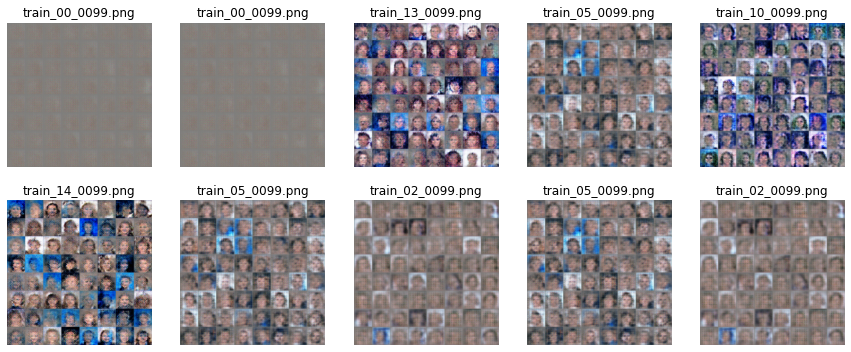

In [65]:
visualize_samples('../outputs/sample-face/')

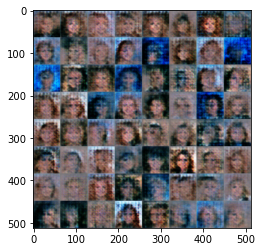

In [68]:
# A clearer image below. As can be seen from the images, the generated data does look like
# a face
i=0
for file in os.listdir('../outputs/sample-face/'):
    img=plt.imread('../outputs/sample-face/'+file)
    if i==2:
        plt.imshow(img)
        break
    i += 1

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [31]:
sess = tf.compat.v1.Session()
load(sess, 'checkpoint')

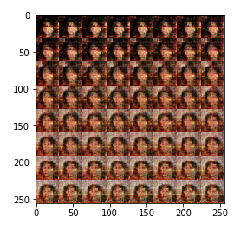

In [24]:
z1 = np.random.uniform(-1, 1, [Z_DIM]).astype(np.float32)
z2 = np.random.uniform(-1, 1, [Z_DIM]).astype(np.float32)
z = []
for i in range(62):
    alpha = i/61.0
    z.append(z1*alpha + (1-alpha)*z2)
batch = np.array(z).astype(np.float32)
with tf.Session() as sess:
    load(sess, 'checkpoint')
    samples = sess.run(G, feed_dict={z: batch, is_training: False} )
plt.imshow(inverse_transform(merge(samples, [8, 8])))

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

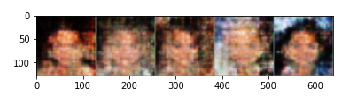

In [45]:
# images generated aren't clear to add smiles
batch_new = np.random.uniform(-1, 1, [BATCH_SIZE,Z_DIM]).astype(np.float32)
smile_yes = np.array([batch[i] for i in [1,3,6,7,9]]) #from whatever that could be figured (mostly random guessing)
smile_no = np.array([batch[i] for i in [29,32,33,34,40]])
smile_vector = np.mean(smile_yes,axis=0) - np.mean(smile_no,axis=0) # (100,)
for i in [3,6,9,12,15]: #random indices where vector added
    batch_new[i] = batch_new[i]+smile_vector
smile_samples = sess.run(G, feed_dict={z: batch_new, is_training: False})
plt.imshow(inverse_transform(merge(smile_samples[[3,6,9,12,15]])))

If faces looks really cool, add bonus 1 point to your score.